**Importing libraries**

In [117]:
library(tidyverse)
library(repr)
library(dplyr)
library(tidymodels)
library(infer)
library(ggplot2)

install.packages("kknn")
install.packages("stringr")
install.packages("cowplot")
install.packages("GGally")

library(stringr)
library(kknn)
library(cowplot)
library(GGally)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



**Demonstrate that the dataset can be read from the web into R**

In [118]:
# downloading data to fiel_path
url <- "https://archive.ics.uci.edu/static/public/45/heart+disease.zip"
temp_file <- tempfile(fileext = ".zip")
download.file(url, destfile = temp_file, mode = "wb")
unzip(temp_file, exdir = "GroupProject/heart_data")
file_path <- "GroupProject/heart_data/cleve.mod"


# reading data into heart_data
heart_data <- read_table(file_path, skip = 20)


── Column specification ────────────────────────────────────────────────────────
cols(
  `63.0` = col_double(),
  male = col_character(),
  angina = col_character(),
  `145.0` = col_double(),
  `233.0` = col_double(),
  true = col_character(),
  hyp = col_character(),
  `150.0` = col_double(),
  fal = col_character(),
  `2.3` = col_double(),
  down = col_character(),
  `0.0` = col_character(),
  fix = col_character(),
  buff = col_character(),
  H = col_character()
)



**Clean and wrangle your data into a tidy format**

In [120]:
# assigning  names to each column
names <- c("age","sex","chest_pain_type","resting_bp",
                    "cholesterol","fasting_blood_sugar", "resting_ecg",
                    "max_heart_rate","exercise_induced_angina","oldpeak",
                    "slope","number_of_vessels_colored","thal","healthy")
colnames(heart_data) <- names

# selecting useful columns (see below for justification of exclusion of oldpeak and slope)
heart_data <- heart_data|> 
    select(age,sex,resting_bp,cholesterol,max_heart_rate, healthy)

head(heart_data)

age,sex,resting_bp,cholesterol,max_heart_rate,healthy
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>
67,male,160,286,108,sick
67,male,120,229,129,sick
37,male,130,250,187,buff
41,fem,130,204,172,buff
56,male,120,236,178,buff
62,fem,140,268,160,sick


In [ ]:
** table 1 **

**Spliting data**

In [125]:
# splitting data into training and testing
set.seed(2004)

#Turning healthy and sex into factors

heart_data |>
  distinct(healthy)
heart_data <- heart_data |>
  mutate(healthy = as_factor(healthy)) |>
  mutate(healthy = fct_recode(healthy, "sick" = "sick", "healthy" = "buff"))

heart_data <-heart_data|>
  mutate(sex=as_factor(sex))|>
  mutate(sex = fct_recode(sex, "male" = "male", "female" = "fem"))

head(heart_data)


heart_disease_split <- initial_split(heart_data,prop = 0.75, strata = healthy)
heart_disease_train <- training(heart_disease_split)
heart_disease_test <- testing(heart_disease_split)

healthy
<fct>
sick
healthy


Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `healthy = fct_recode(healthy, sick = "sick", healthy =
  "buff")`.
Caused by warning:
! Unknown levels in `f`: buff”
Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `sex = fct_recode(sex, male = "male", female = "fem")`.
Caused by warning:
! Unknown levels in `f`: fem”


age,sex,resting_bp,cholesterol,max_heart_rate,healthy
<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<fct>
67,male,160,286,108,sick
67,male,120,229,129,sick
37,male,130,250,187,healthy
41,female,130,204,172,healthy
56,male,120,236,178,healthy
62,female,140,268,160,sick


In [ ]:
**Table 2**

In [127]:
# I plan to use Trestbps, Cholesteral and Max_Heart_Rate as predictors
# None of the rows have missing data since we already addressed this issue when importing the data
# Datasets below shows the count for healhty and sick observations and mean of each of our predictors 


heart_disease_info <- heart_disease_train |>
    mutate(observation_count = n()) |>
    mutate(mean_resting_bp = mean(resting_bp)) |>
    mutate(mean_cholesterol = mean(cholesterol)) |>
    mutate(mean_max_heart_rate = mean(max_heart_rate)) |>
    mutate(mean_age = mean(age)) |>
    #mutate(mean_number_of_blood_vesels = mean(number_of_vessels_colored)) |>
    select(observation_count,mean_age,mean_resting_bp,mean_cholesterol,mean_max_heart_rate) |>
    distinct()

sick_data <- heart_disease_train |>
    filter(healthy == "sick") |>
    mutate(observation_count = n()) |>
    mutate(sick_mean_resting_bp = mean(resting_bp)) |>
    mutate(sick_mean_cholesterol = mean(cholesterol)) |>
    mutate(sick_mean_max_heart_rate = mean(max_heart_rate)) |>
    mutate(sick_mean_age = mean(age)) |>
    #mutate(sick_mean_number_of_blood_vesels = mean(number_of_vessels_colored)) |>
    select(observation_count,sick_mean_age,sick_mean_resting_bp,sick_mean_cholesterol,sick_mean_max_heart_rate) |>
    distinct()

healthy_data <- heart_disease_train |>
    filter(healthy == "buff") |>
    mutate(observation_count = n()) |>
    mutate(healthy_mean_resting_bp = mean(resting_bp)) |>
    mutate(healthy_mean_cholesterol = mean(cholesterol)) |>
    mutate(healthy_mean_max_heart_rate = mean(max_heart_rate)) |>
    mutate(healthy_mean_age = mean(age)) |>
    #mutate(healthy_mean_number_of_blood_vesels = mean(healthy_number_of_vessels_colored)) |>
    select(observation_count,healthy_mean_age,healthy_mean_resting_bp,healthy_mean_cholesterol,healthy_mean_max_heart_rate) |>
    distinct()

heart_disease_info
sick_data
healthy_data

observation_count,mean_age,mean_resting_bp,mean_cholesterol,mean_max_heart_rate
<int>,<dbl>,<dbl>,<dbl>,<dbl>
226,54.57522,131.4027,247.0354,149.5177


observation_count,sick_mean_age,sick_mean_resting_bp,sick_mean_cholesterol,sick_mean_max_heart_rate
<int>,<dbl>,<dbl>,<dbl>,<dbl>
103,56.42718,134.9417,248.699,139.2233


observation_count,healthy_mean_age,healthy_mean_resting_bp,healthy_mean_cholesterol,healthy_mean_max_heart_rate
<int>,<dbl>,<dbl>,<dbl>,<dbl>


In [ ]:
**table 3**

In [29]:
#summarizing the data by getting number of sick and healthy
healthy_proportions <- heart_disease_train |>
                      group_by(healthy) |>
                      summarize(n = n()) |>
                      mutate(percent = 100*n/nrow(heart_disease_train))
healthy_proportions

healthy,n,percent
<fct>,<int>,<dbl>
sick,103,45.57522
healthy,123,54.42478


In [ ]:
**table 4**

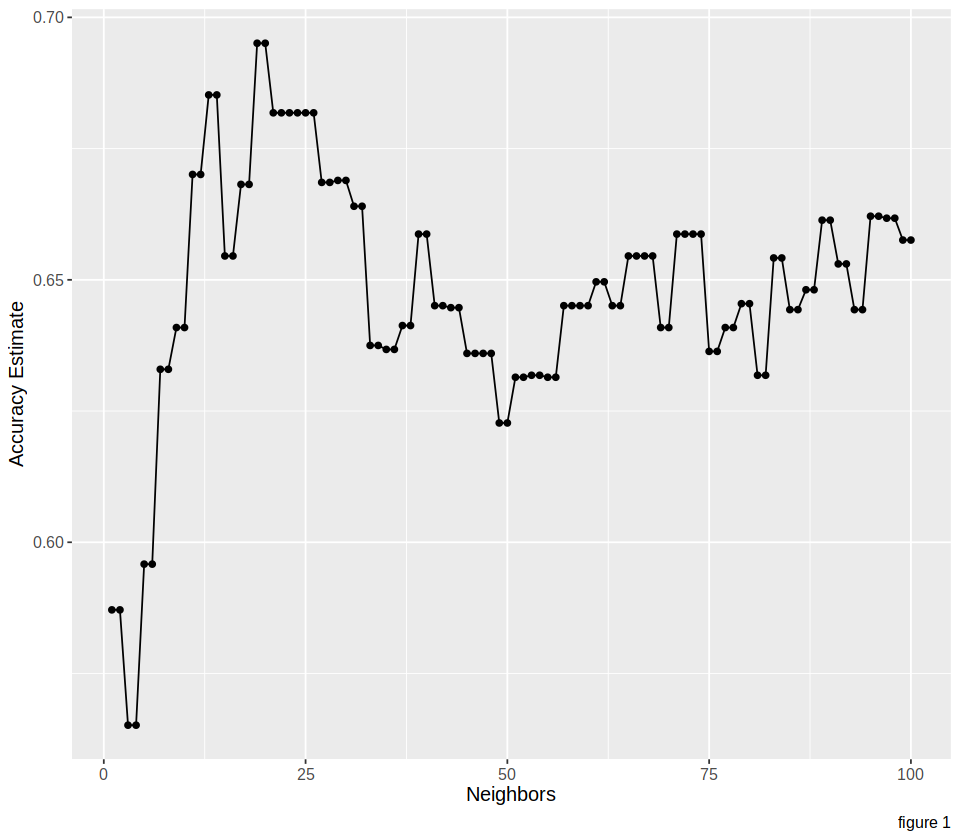

In [128]:
#Classifying Part A: choosing the K value
set.seed(1920)
heart_recipe <- recipe(healthy ~ age+resting_bp+cholesterol+max_heart_rate, data = heart_disease_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

knn_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

heart_vfold <- vfold_cv(heart_disease_train, v = 10, strata = healthy)
k_vals <- tibble(neighbors = seq(from = 1, to = 100, by = 1))

knn_results <- workflow() |>
  add_recipe(heart_recipe) |>
  add_model(knn_spec) |>
  tune_grid(resamples = heart_vfold, grid = k_vals) |>
  collect_metrics() 

accuracies <- knn_results |>
  filter(.metric == "accuracy")

accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate", caption = "figure 1") + 
  theme(text = element_text(size = 12))

accuracy_vs_k

**Choosing our K**: 
Looking at the plot above, we can see that setting the K=19 will give us the highest accuracy which is at about 68%. 
Therefore we choose K to be 19. 

In [129]:
#Classifying the data
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 19) |>
  set_engine("kknn") |>
  set_mode("classification")

knn_fit <- workflow() |>
  add_recipe(heart_recipe) |>
  add_model(knn_spec) |>
  fit(data = heart_disease_train)
knn_fit


heart_test_predictions <- predict(knn_fit, heart_disease_test) |>
  bind_cols(heart_disease_test)

heart_test_predictions

heart_test_predictions |>
  metrics(truth = healthy, estimate = .pred_class) |>
  filter(.metric == "accuracy")


confusion <- heart_test_predictions |>
             conf_mat(truth = healthy, estimate = .pred_class)
confusion

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(19,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.3097345
Best kernel: rectangular
Best k: 19

.pred_class,age,sex,resting_bp,cholesterol,max_heart_rate,healthy
<fct>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<fct>
healthy,67,male,120,229,129,sick
healthy,41,female,130,204,172,healthy
healthy,56,male,120,236,178,healthy
sick,63,male,130,254,147,sick
healthy,53,male,140,203,155,sick
healthy,58,female,150,283,162,healthy
healthy,58,female,120,340,172,healthy
sick,66,female,150,226,114,healthy
healthy,43,male,150,247,171,healthy


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.6710526


          Truth
Prediction sick healthy
   sick      17       7
   healthy   18      34

In [1]:
#Calculating the accuracy, precision, and recall in order to better understand the errors most important in our application. 

Accuracy<- (17+34)/(17+7+18+34)
Accuracy
#67%

Precision<-17/(17+7)
Precision
#71%

Recall<-17/(17+18)
Recall 
#49%

[1] 0.6710526

[1] 0.7083333

[1] 0.4857143

In [ ]:
**table 5**

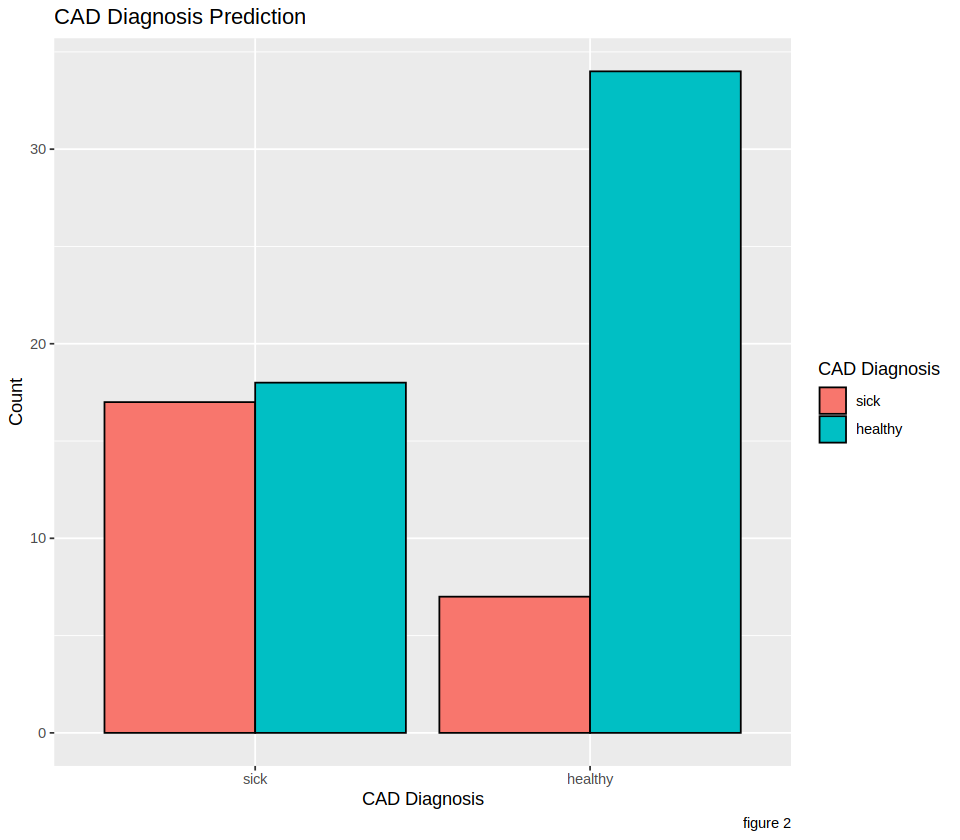

In [130]:
bar_plot <- heart_test_predictions |>
    ggplot(aes(x = healthy,fill = .pred_class)) +
    geom_bar(position = "dodge", color = "black") +
    labs(title = "Assessing the Accuracy of CAD Diagnosis Predictions Based on Actual Observations", 
         x = "Actual Observations", 
         y = "Count",
         fill = "CAD Diagnosis",
         caption = "figure 2")

bar_plot

In [131]:
options(repr.plot.height = 3, repr.plot.width = 4)

age_cholesterol_plot <- heart_test_predictions |>
    ggplot(aes(x = cholesterol, y = age, color = healthy)) +
    geom_point(alpha = 0.6) +
    labs(x = "Cholesterol Level (mg/dL)", y = "Age (years)", color = "CAD Diagnosis", caption = "figure 3") +
    ggtitle("Relationship Between Blood Cholesterol Levels (mg/dL) and Patient Age (years) in CAD Predictions")

age_resting_bp_plot <- heart_test_predictions |>
    ggplot(aes(x = resting_bp, y = age, color = healthy)) +
    geom_point(alpha = 0.6) +
    labs(x = "Resting Blood Pressure (mmHg)", y = "Age (years)", color = "CAD Diagnosis", caption = "figure 4")+
    ggtitle("Relationship Between Resting Blood Pressure (mmHg) and Patient Age (years) in CAD Predictions")

age_max_heart_rate_plot <- heart_test_predictions |>
    ggplot(aes(x = max_heart_rate, y = age, color = healthy)) +
    geom_point(alpha = 0.6) +
    labs(x = "Max Heart Rate (BPM)", y = "Age (years)", color = "CAD Diagnosis", caption = "figure 5") +
    ggtitle("Relationship Between Maximum  Heart Rate (BPM) and Age (years) of the Patient in CAD Predictions")

resting_bp_cholesterol_plot <- heart_test_predictions |>
    ggplot(aes(x = resting_bp, y = cholesterol, color = healthy)) +
    geom_point(alpha = 0.6) +
    labs(x = "Resting Blood Pressure (mmHg)", y = "Cholesterol Level (mg/dL)", color = "CAD Diagnosis", caption = "figure 6")+
    ggtitle("Relationship Between Resting Blood Pressure (mmHg) and Blood Cholesterol Levels (mg/dL) in CAD Predictions")

max_heart_rate_cholesterol_plot <- heart_test_predictions |>
    ggplot(aes(x = max_heart_rate, y = cholesterol, color = healthy)) +
    geom_point(alpha = 0.6) +
    labs(x = "Max Heart Rate (BPM)", y = "Cholesterol Level (md/dL)", color = "CAD Diagnosis", caption = "figure 7")+
    ggtitle("Relationship Between Maximum Heart Rate (BPM) and Blood Cholesterol Levels (mg/dL) in CAD Predictions")

resting_bp_max_heart_rate_plot <- heart_test_predictions |>
    ggplot(aes(x = max_heart_rate, y = resting_bp, color = healthy)) +
    geom_point(alpha = 0.6) +
    labs(x = "Max Heart Rate (BPM)", y = str_wrap("Resting Blood Pressure (mmHg)", width = 20), color = "CAD Diagnosis", caption = "figure 8")+
    ggtitle("Relationship Between Maximum Heart Rate (BPM) and Resting Blood Pressure (mmHg) in CAD Predictions")

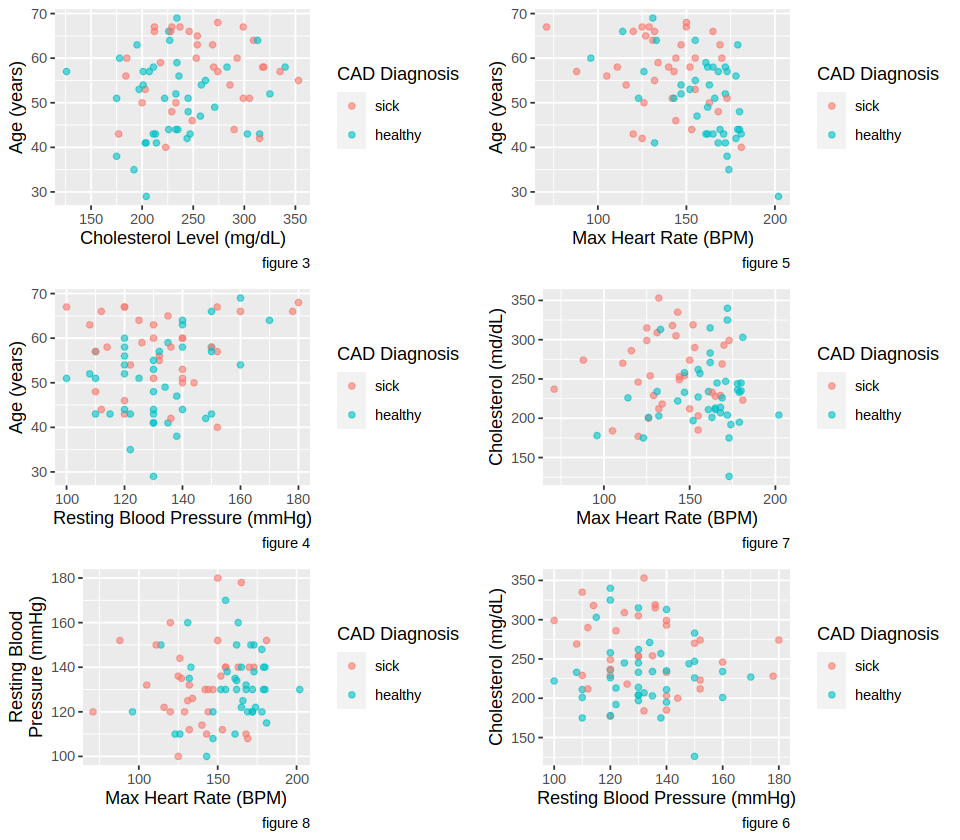

In [132]:
options(repr.plot.width = 8, repr.plot.height = 7)

scatter_plot_panel <- plot_grid(age_cholesterol_plot, 
                                age_max_heart_rate_plot, 
                                age_resting_bp_plot,
                                max_heart_rate_cholesterol_plot, 
                                resting_bp_max_heart_rate_plot, 
                                resting_bp_cholesterol_plot,ncol = 2, nrow = 3)

scatter_plot_panel